Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Kathrin Root, Alexander Wendt, Patrick Weygoldt

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [38]:
# import packages here
from pathlib import Path

import utils_project1 as utils

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

jupyter_black.load()

## Context
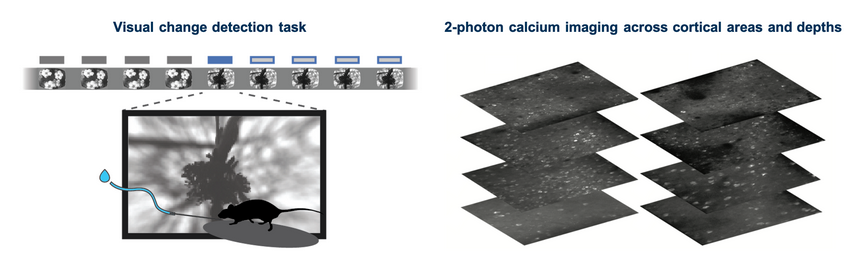

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

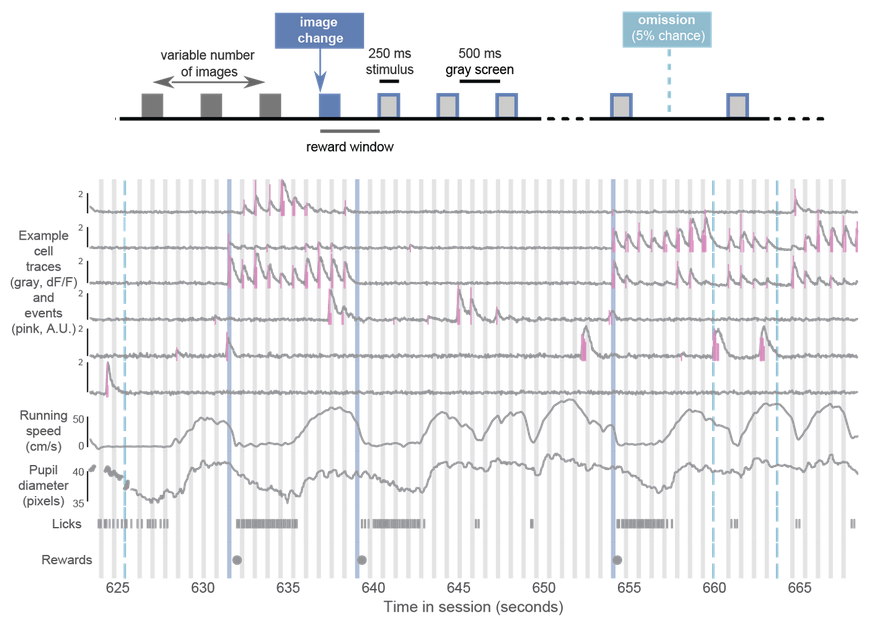

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

As you can see on the plots, our ROIs did not excibit a particular spacial structure in neither of the stimulus features. 

In [39]:
def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


# change if necessary
datapath = "../data/"
data = utils.load_data(datapath)
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
print(data["stim_epoch_table"])
print(data["stim_table"])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
0                   1.0        225.0          0.0     747.0     807.0
1               

## Downloading OOPSI Algorithm for the Spike Inference 
* Link to the Github repository: https://github.com/liubenyuan/py-oopsi
* Link to the paper: http://stat.columbia.edu/~liam/research/pubs/vogelstein-fast.pdf 
    * published in: Journal of Neurophysiology, 104(6): 3691-3704

In [40]:
download_url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
file_name = "oopsi.py"
if not Path(file_name).exists():
    !curl -L $download_url -o $file_name

import oopsi as ops

In [41]:
# define a nice color palette
color_directions = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
    "#ffc107",
    "#ff9800",
    "#f44336",
    "#ad1457",
    "#000000",
]
color_orientations = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
]
color_temporal_frequencies = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
color_temporal_frequencies = color_temporal_frequencies[::-1]

# 1. Data Exploration <a class="anchor" id="data_exploration"></a>

## 1.1 Distribution of Sample Size of Displayed Orientations 
As first step of the data exploration, we looked at the sample size of the trials for each orientation.
We found that the displayed orientations are not equally distributed. There are around 75 trials for each orientation and 30 trials for the blank stimulus (which is 5 % of the trials).

Orientations: [  0.  45.  90. 135. 180. 225. 270. 315.  nan],
Counts Orientation: [75 75 75 74 75 75 75 74 30]

Temporal Frequencies: [ 1.  2.  4.  8. 15. nan],
Counts Temporal Frequencies:[120 120 119 120 119  30]

Blank Sweeps: [0. 1.],
Counts Black Sweeps: [598  30]


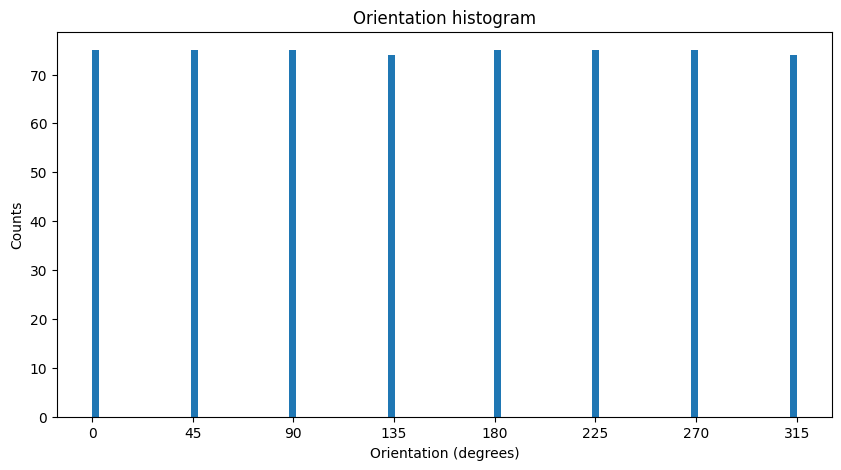

In [42]:
# ploting the orientation histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(data["stim_table"]["orientation"], bins=100)
ax.set_xlabel("Orientation (degrees)")
ax.set_ylabel("Counts")
ax.set_title("Orientation histogram")
ax.set_xticks(np.arange(0, 360, 45))

# print out the unique values and their counts for orientation, temporal frequency and blank sweeps
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(f"Orientations: {uniq},\nCounts Orientation: {coutnts}\n")
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(f"Temporal Frequencies: {freqs},\nCounts Temporal Frequencies:{counts_freqs}\n")
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(f"Blank Sweeps: {blanks},\nCounts Black Sweeps: {counts_blanks}")

Then, we looked at the distribution throughout the epochs. We found that the sample size of trials for each displayed orientation is also not equally distributed across the three stimulus epochs. 

In [43]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(f"Orientations and counts for the first epoch: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(f"Orientations and counts for the second epoch: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(f"Orientations and counts for the third epoch: {uniq}, {coutnts}\n")

Orientations and counts for the first epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 25 22 25 24 29 18 19 12]

Orientations and counts for the second epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [23 26 19 22 21 22 28 27 12]

Orientations and counts for the third epoch: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 24 34 27 29 24 29 28  6]



## 1.2 Sampling Rate 
We determined the sampling rate and the duration of the stimulus presentation, which are important for further analysis steps.
Sampling rate is around 30 Hz (30 frames per second), and the stimulus duration is 2 seconds long.

In [44]:
# the sampling rate:
print(f"Unique values of the sampling rate: {1 / np.unique(np.diff(data['t']))}")
# the stimulus time:
print(
    f'Stimulus duration for one trial: {data["t"][data["stim_table"]["end"][0].astype(int)] - data["t"][data["stim_table"]["start"][0].astype(int)]}'
)

Unique values of the sampling rate: [30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797
 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.06614552
 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552
 30.06614552 30.06614552 30.06614552]
Stimulus duration for one trial: 1.9952200000000033


## 1.3 Maximum Projection of the ROIs
To check if the ROI masks are segmented correctly, we plotted the maximum projection of the ROIs and the masks on top of it. The maximum projection is the maximum intensity value of each pixel in the z-stack. The maximum projection of the ROIs and the masks are shown in the figure below. The ROIs and the masks are segmented well. The ROIs are segmented in the correct location and the masks are segmented in the correct shape, judging from the maximum projection.

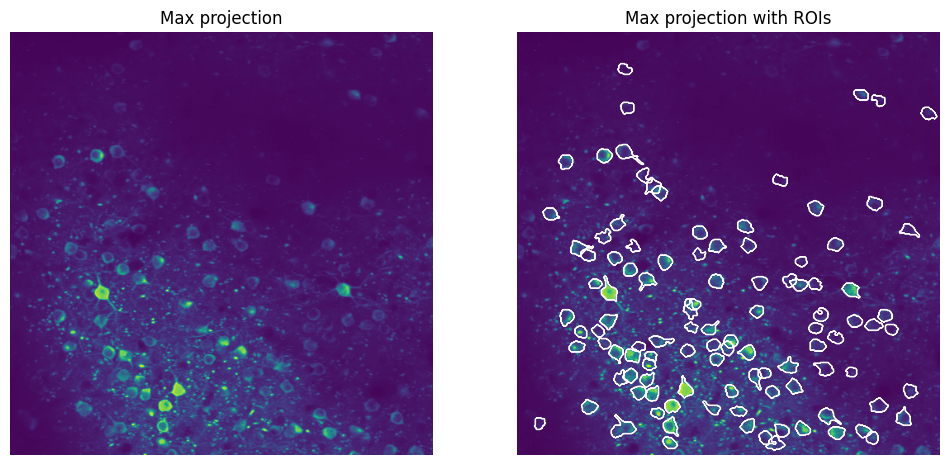

In [45]:
# plotting the max projection and the first ROI mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["max_projection"])

for i in range(len(data["roi_masks"][:, 0, 0])):
    plt.contour(data["roi_masks"][i, :, :], colors="white", linewidths=0.5)

ax[0].set_title("Max projection")
ax[1].set_title("Max projection with ROIs")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

## 1.4 Displaying the dF/F Traces 
There are 106 different ROIs and to plot them nicely on top of each other we normalized them to the maximum value of the trace.
To visualize the stimulation phases, we used the start and stop times in the stim_epoch_table. The grey background indicates the start and stop times of the drifting grating presentation. 

In [46]:
# get the start and end times of the drifting grating stimulus
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)

print(
    f'Durations of the drifting graiting stimulus per stimulus epoch: {data["t"][np.array(end_times)] - data["t"][np.array(start_times)]}'
)

Durations of the drifting graiting stimulus per stimulus epoch: [599.50393 599.52014 683.60274]


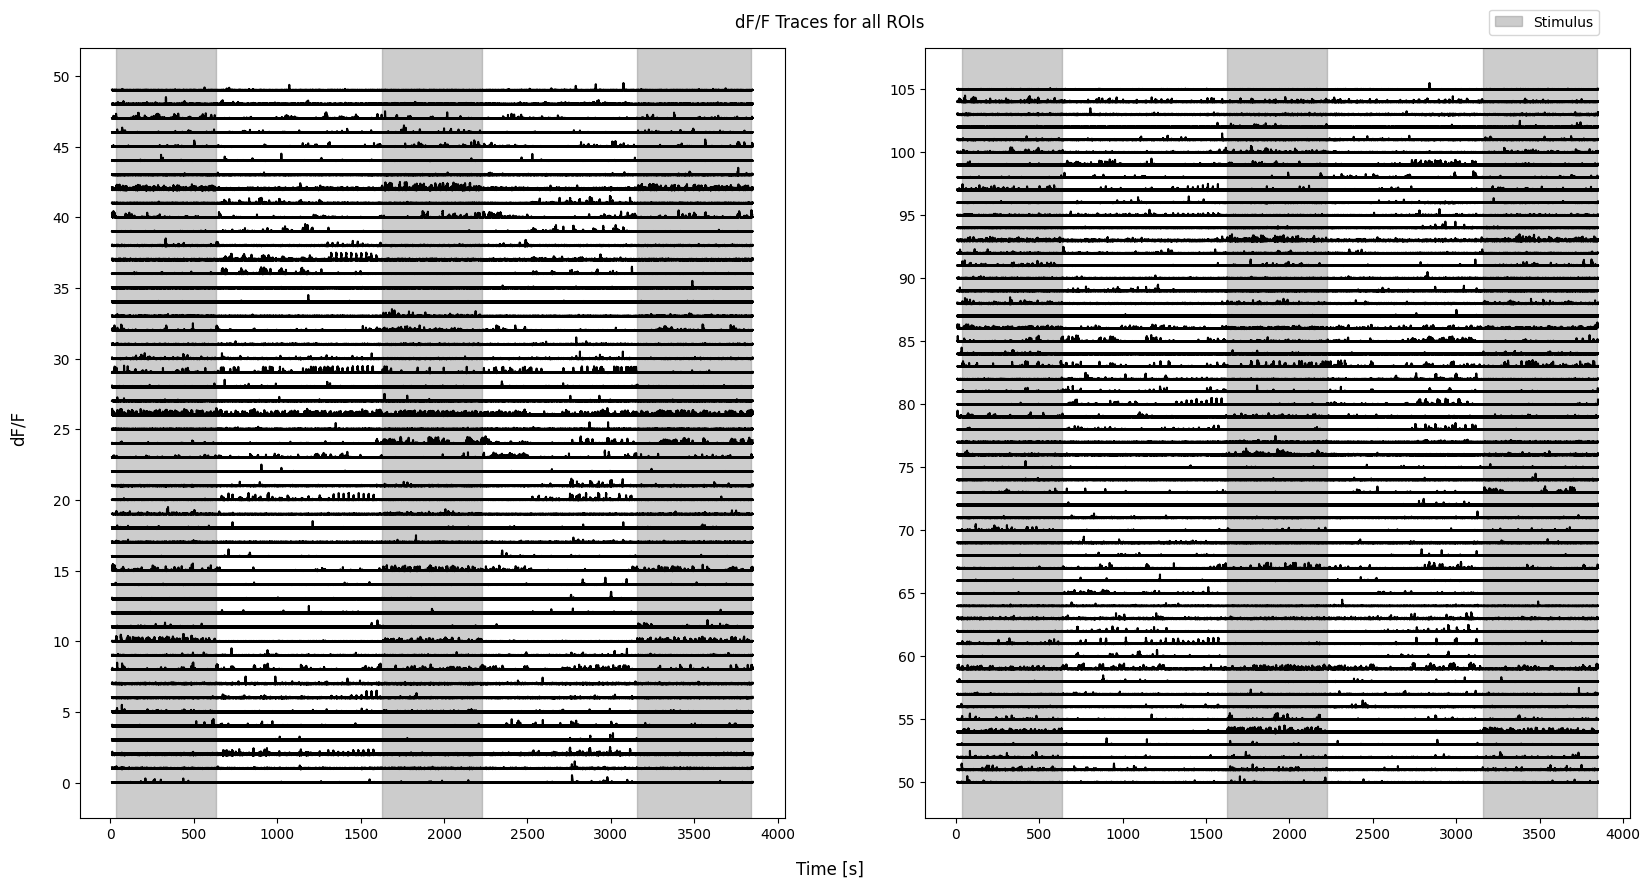

In [76]:
# ploting the dF/F traces for all ROIs with the stimulus times indicated in gray
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
# plot the start and end times of the stimulus as gray areas
for i, s in enumerate(start_times):
    axs[0].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")
    if i == 0:
        axs[1].axvspan(
            data["t"][s],
            data["t"][end_times[i]],
            alpha=0.4,
            color="gray",
            label="Stimulus",
        )
    else:
        axs[1].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
axs[1].legend(bbox_to_anchor=(0.8, 1.05), loc="upper left", borderaxespad=0.0)
fig.suptitle(
    "dF/F Traces for all ROIs",
    x=0.5,
    y=0.915,
)
fig.supxlabel("Time [s]", x=0.5, y=0.05)
fig.supylabel("dF/F", x=0.09, y=0.5)
plt.show()

## 1.5 Visualizing Example Traces 
We plotted three example traces of ROIs with high activity (10, 29, 54). We can see that the activity differed between three ROIs and that ROI 10 and 54 are more active during stimulation presentation and ROI 29 between the stimuli. This showed us, that we need to be careful in later analysis, that the ROIs are not more active inbetween the stimulation than during the stimulation.

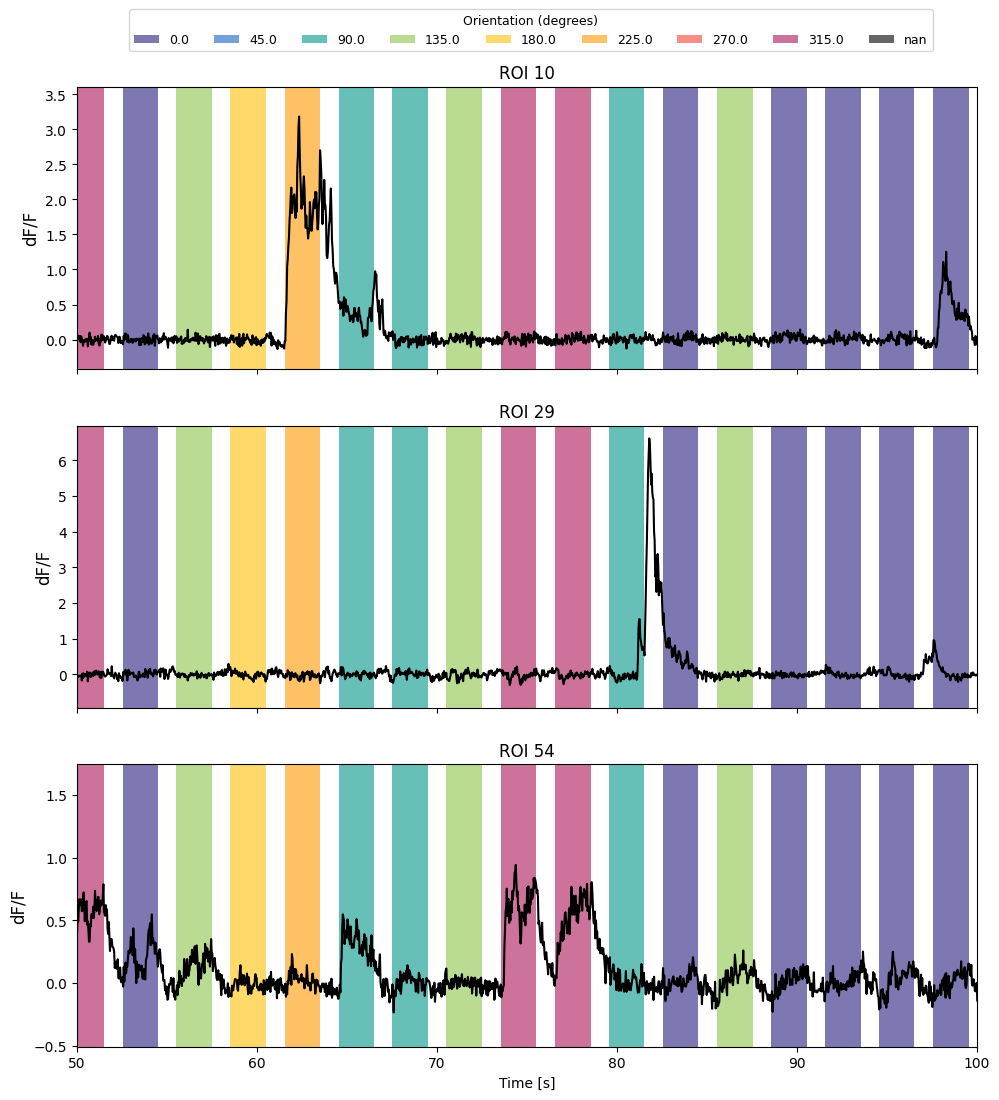

In [77]:
# define orientation and colors
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

# define rois for the plot
rois = [
    10,
    29,
    54,
]

fig, axs = plt.subplots(len(rois), figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0.2, left=0.15, right=0.9, top=0.9, bottom=0.1)
# define xlim for the plot
limits = [50, 100]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=color_directions[colors_orentation[indx]],
            lw=0,
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=color_directions[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time [s]")

axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.1, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=9,
    title="Orientation (degrees)",
    title_fontsize=9,
    ncol=9,
)
plt.show()

## 1.6 Conclusion for Data Exploration:
1. The sample size of the trials for each orientation in each stimulus epoch is not equally distributed.
2. We set the sampling rate for this project to 30 Hz. 
3. In the calcium trace data, we can clearly see the activity of the ROIs in response to the stimulus.
4. In ROI 29 we can see that the cell is spiking inbetween the trials, and we need to handle this!

# 2. Orientation Selectivity in the dF/F Traces 

As a control for the spike inference which we want to do later, we looked at the mean dF/F for each orientation of the average response in the trials. We will later use this to visually check if the spike inference resulted in reasonable results.

## 2.1 Polar Plot of Example ROI 

To show the tuning of the ROI, we plotted polar plots for one example ROI. For this we calculated the average response in the trials and took the mean per orientation with the corresponding standard deviation.

In [49]:
# define x axis for the polar plots (in radians)
orientations_polar_plot = np.deg2rad(
    np.sort(
        data["stim_table"]["orientation"].unique()[
            ~np.isnan(data["stim_table"]["orientation"].unique())
        ]
    )
)

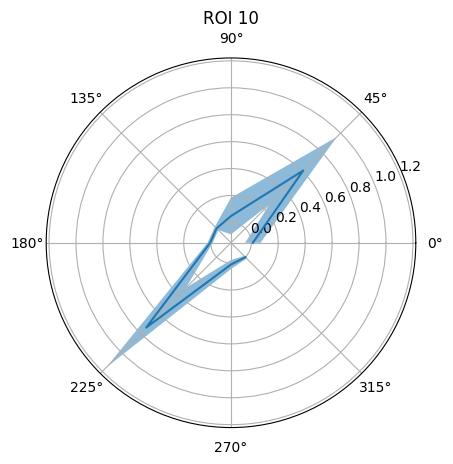

In [50]:
# caluclate the mean and std of the calcium response for each orientation for each roi
# see utils_project1.py for the functions dff_orientation

mean_calcium_orientation, std_calcium_orientation = utils.dff_orientation(data)

# define the ROI for the plot
roi = 10
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

ax.plot(
    orientations_polar_plot,
    mean_calcium_orientation[roi, :],
)
ax.fill_between(
    orientations_polar_plot,
    mean_calcium_orientation[roi, :] - std_calcium_orientation[roi, :],
    mean_calcium_orientation[roi, :] + std_calcium_orientation[roi, :],
    alpha=0.5,
)
ax.set_title(f"ROI {roi}")
plt.show()

ROI 10 shows promissing results in terms of direction / orientation selectivity.

## 2.2 How does the Temporal Frequency of the Stimulus Influence the Orientation Selectivity?

To explore the influence of the temporal frequency of the stimulus on the orientation selectivity of the ROIs, we plotted the mean calcium activity per orientation for each temporal frequency for one example ROI in polar plots. This showed us that the temporal frequency influences the orientation selectivity of the ROIs. Knowing this, we later analyzed the influence of the temporal frequency on the orientation / direction selectivity of the ROIs in more detail.

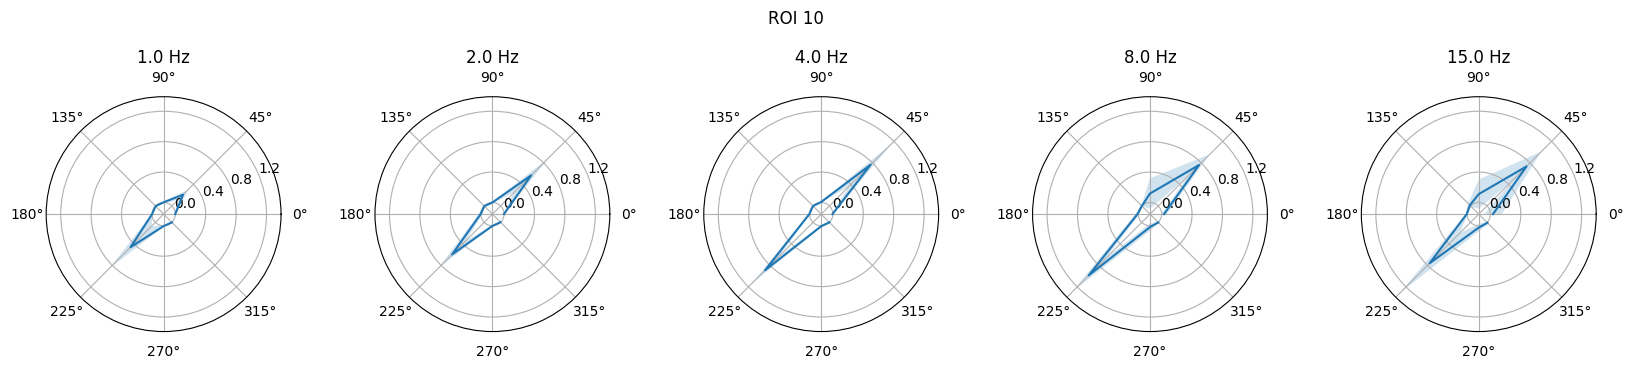

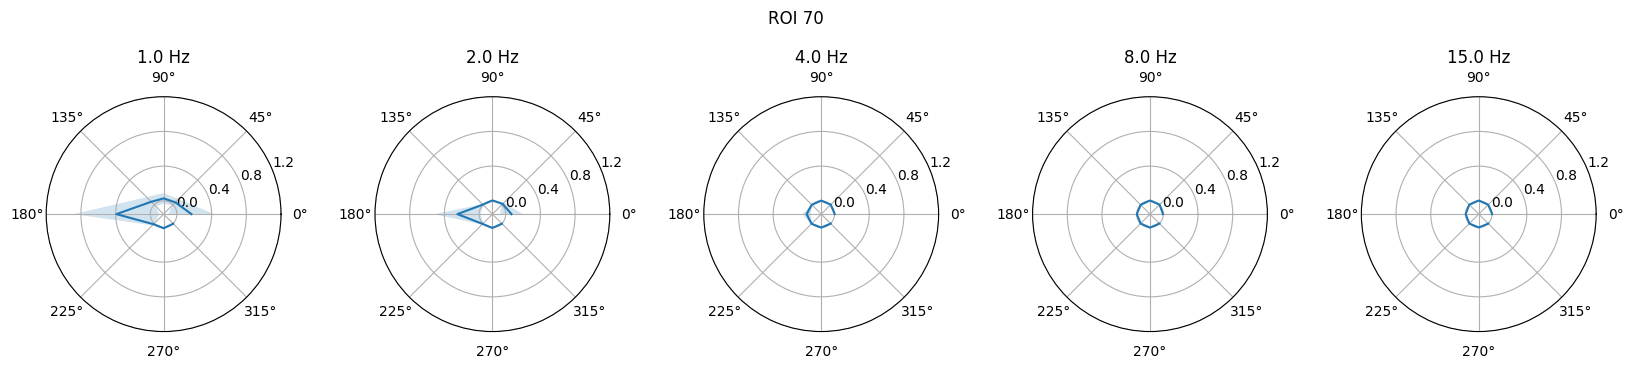

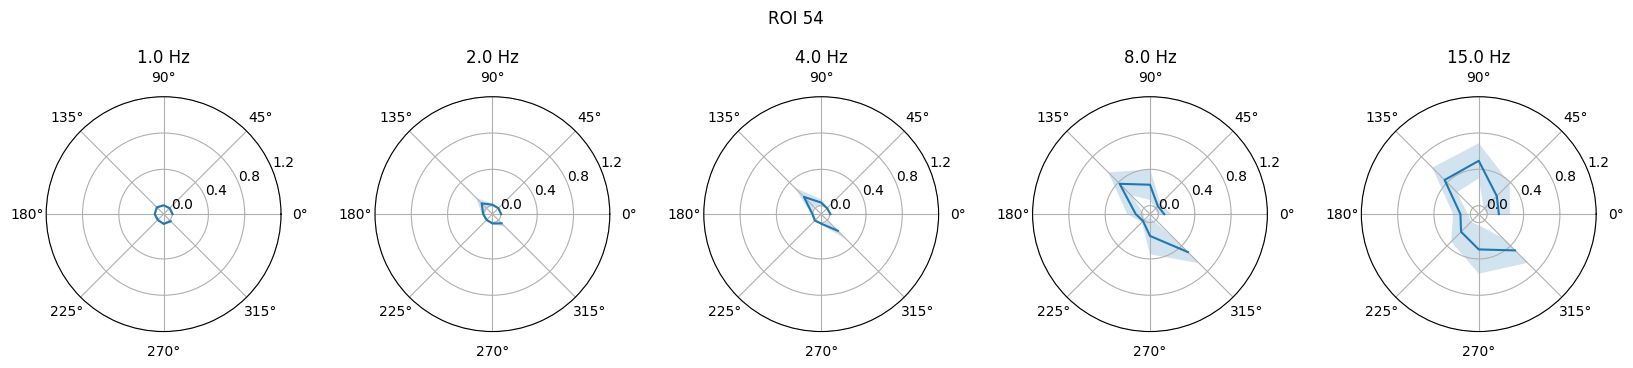

In [51]:
(
    mean_calcium_orientation_temp,
    std_calcium_orientation_temp,
) = utils.dff_orientation_temporal_frequency(data)
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

# selct a roi
rois = [10, 70, 54]
for roi in rois:
    # plot a polar plot for for each orientation and temporal frequency
    fig, axs = plt.subplots(
        1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
    )
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for i, ax in enumerate(axs.flat):
        ax.plot(
            orientations_polar_plot,
            mean_calcium_orientation_temp[roi, :, i],
        )
        # add std to the plot
        ax.fill_between(
            orientations_polar_plot,
            mean_calcium_orientation_temp[roi, :, i]
            - std_calcium_orientation_temp[roi, :, i],
            mean_calcium_orientation_temp[roi, :, i]
            + std_calcium_orientation_temp[roi, :, i],
            alpha=0.2,
        )
        ax.set_title(f"{temporal_frequencies[i]} Hz")
        ax.set_yticks(np.arange(0, 1.5, 0.4))
        fig.suptitle(f"ROI {roi}", y=0.70)
plt.show()

We can see here clearly that the temporal frequency is influencing the response of the ROI. The higher the frequency, the higher the response in ROI 10. But this is reversed for ROI 70.

# 3. Transforming the Calcium Traces to Spikes
To infere spikes from the calcium traces we used the algorithm from coding lab 3, py-oopsi. This code runs the oopsi algorithm one time and saves the inferred spikes in the data directory. 

In [52]:
# check if spike data is already saved
data_path = Path("../data")

# create the data path if it does not exist
data_path.mkdir(exist_ok=True)
# load the data
if Path(data_path / "spike_data.npy").exists():
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        print(n.shape)
        print(roi)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

## 3.1 Thresholding the Spike Probability
The oopsi algorithm returns the probability of a spike occurring at each time point. We can use a threshold to decide whether a spike has occurred or not. The returned spike probability is a value between 0 and 1. After visual assessment of the spike data compared to the calcium traces, we chose a threshold of 0.2.


In [53]:
# threshold the spike data at get the time points where the spike occurs
threshold = 0.2
spike_data[spike_data < threshold] = 0
spike_data[spike_data >= threshold] = 1
spike_data = spike_data.astype(int)
# get the spike times for each ROI
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] >= 0.5])
spike_times = np.array(spike_times, dtype=object)

## 3.2 Plotting the Spikes on Top of the dF/F 
We then plotted the spikes above the calcium traces to make sure that the thresholding was done correctly. We also plotted the spikes on top of the calcium traces to make sure that the spikes were aligned with the calcium traces.

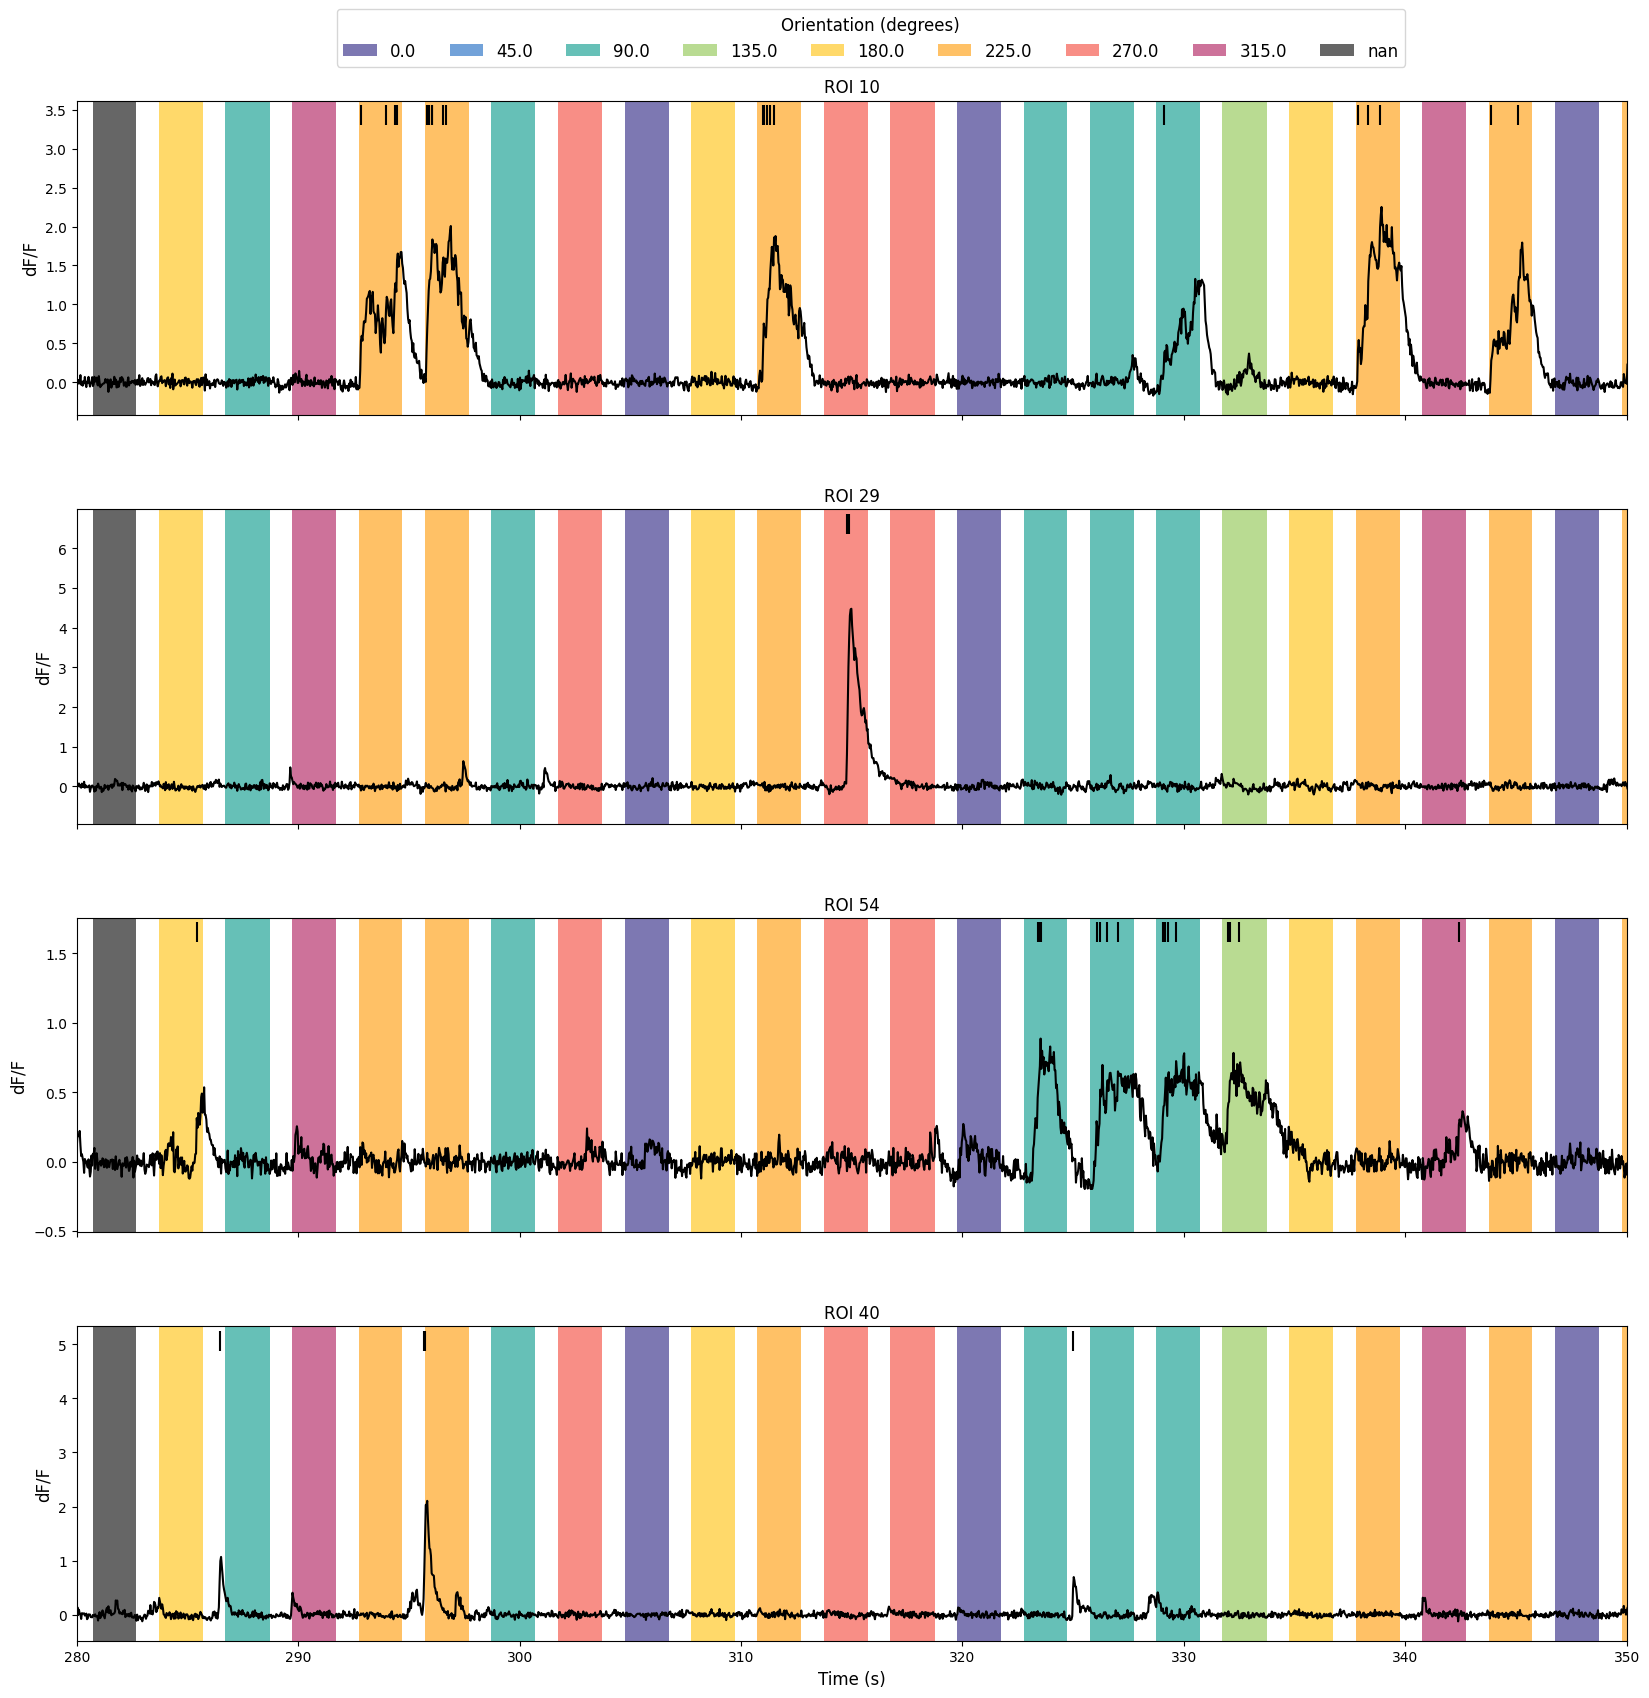

In [54]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = [10, 29, 54, 40]

fig, axs = plt.subplots(len(rois), figsize=(20, 20), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [280, 350]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    axs[i].scatter(
        spike_times[roi],
        np.ones(len(spike_times[roi])) * np.max(data["dff"][roi]) + 0.01,
        c="k",
        marker="|",
        s=200,
        zorder=10,
    )
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=color_directions[colors_orentation[indx]],
            linewidth=0,
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=color_directions[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time [s]", fontsize=12)


axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation (degrees)",
    title_fontsize=12,
    ncol=9,
)
plt.show()

# 4. Choosing Orientation Selective Cells with Permutation Testing 

Before testing cells for orientation or direction selectivity, we first filtered the dataset to only get ROIs that are active in the correct periods. We did this by looking at the mean activity of the cells in the stimulus presentation period. 

i) We also excluded ROIs that had no activity at all. 

ii) We exclusively selected ROIs that had one or more spikes in five or more trials for at least one orientation. This was necessary because otherwise we would have had a lot of false positives in the permutation testing.

iii) As an additional criterion, we only chose ROIs that had at least 75% of their activity in the stimulus presentation period. We chose 75% as our threshold because at 50% we can't be sure if the ROI is really reacting to the stimulus. 

## 4.1 Applying Restrictions / Filtering the Data 

In [55]:
# i) check if the ROI is active for at least one orientation
rois_sum = np.sum(spike_data, axis=1) > 0
qualifying_rois = np.where(rois_sum)[0]

# ii) orientation selctivity to ROIs that have at leat 5 trials where the neuron fired for at least one orientation
rois_active = []
for roi in qualifying_rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_direction_unique = [
        len(np.where(counts[dirs == d] > 0)[0]) for d in np.unique(dirs)
    ]
    empty_check = np.array(counts_direction_unique) >= 5
    if np.sum(empty_check) > 0:
        rois_active.append(roi)

print("Preliminary number of ROIs that are orientation selective: ", len(rois_active))
print(rois_active)

Preliminary number of ROIs that are orientation selective:  27
[5, 10, 11, 18, 19, 29, 33, 40, 42, 46, 48, 50, 51, 52, 54, 55, 61, 67, 70, 77, 83, 84, 91, 97, 99, 100, 102]


In [56]:
# Calculating the spike counts for each ROI inbetween the stimulus
counts_inbetween = np.zeros(data["dff"].shape[0], dtype=object)
start_times_inbetween = data["stim_table"]["end"].to_numpy().astype(int)
end_times_inbetween = data["stim_table"]["start"].to_numpy().astype(int)[1:]

for roi in range(data["dff"].shape[0]):
    idx_spikes = np.where(spike_data[roi] == 1)[0]
    counts_inbetween_roi = []
    for i, (s, e) in enumerate(zip(start_times_inbetween, end_times_inbetween)):
        ori = data["stim_table"]["orientation"][i]
        if np.isnan(ori):
            continue
        counts_inbetween_roi.append(np.sum((idx_spikes >= s) & (idx_spikes <= e)))
    counts_inbetween[roi] = np.sum(np.array(counts_inbetween_roi))

In [57]:
# iii) Exclude ROIs that have less than 75% of their spikes in the stimulus
qualifying_rois_snr = []
for roi in rois_active:
    dirs, counts_stim = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_inb = counts_inbetween[roi]
    # check if 75% of the total spikes are in the stimulus
    if np.sum(counts_stim) / (counts_inb + np.sum(counts_stim)) >= 0.75:
        qualifying_rois_snr.append(roi)
print(f"These ROIs qualify for further analysis: {qualifying_rois_snr}")
print(f"Number of ROIs that qualify: {len(qualifying_rois_snr)}")

These ROIs qualify for further analysis: [10, 19, 33, 42, 51, 52, 54, 55, 70, 84, 91, 102]
Number of ROIs that qualify: 12


## 4.2 Permutation Testing 

In the next step, we did a permutation test for the first Fourier component of the stimulus to test for direction selectivity and for the second Fourier component to test for orientation selectivity.

In [58]:
# Direction
# calculate the permutation of the qualifying rois
rois_sig_direction = []
for roi in qualifying_rois_snr:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    p = utils.testTuning(counts, dirs, psi=1, niters=1000)[0]
    if p < 0.01:
        rois_sig_direction.append(roi)
print(
    f"These ROIs are significant in direction: {rois_sig_direction}, total {len(rois_sig_direction)} ROIs"
)

# Orientation
# calculate the permutation of the qualifying rois
rois_sig_orientation = []
for roi in qualifying_rois_snr:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    p = utils.testTuning(counts, dirs, psi=2, niters=1000)[0]
    if p < 0.01:
        rois_sig_orientation.append(roi)
print(
    f"These ROIs are significant in orientation: {rois_sig_orientation}, total {len(rois_sig_orientation)} ROIs"
)

These ROIs are significant in direction: [10, 19, 33, 42, 51, 54, 55, 70, 84, 91, 102], total 11 ROIs
These ROIs are significant in orientation: [10, 19, 33, 42, 51, 55, 70, 84, 91, 102], total 10 ROIs


As you can see, we have approximately the same number of direction and orientation selective ROIs and the lists contain many overlapping ROIs. Only ROI 54 is exclusively direction selective.

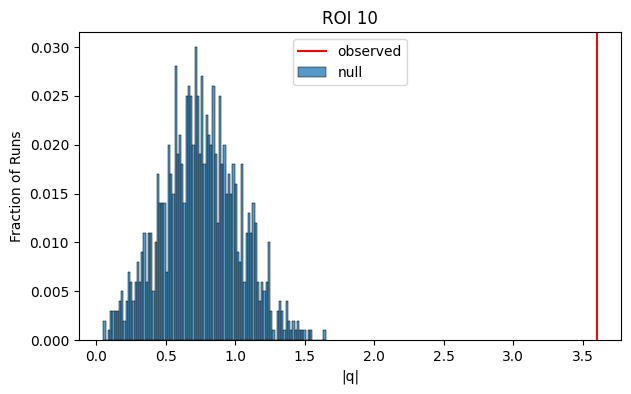

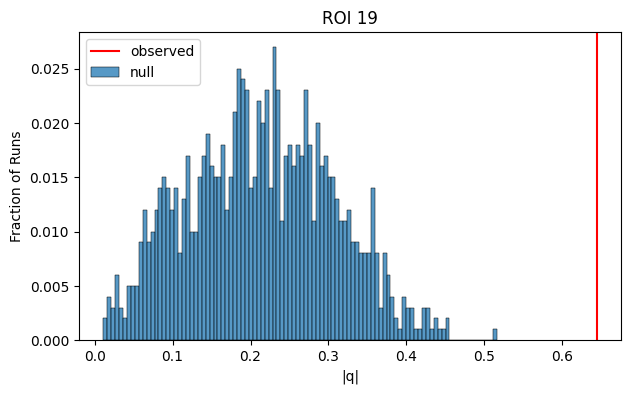

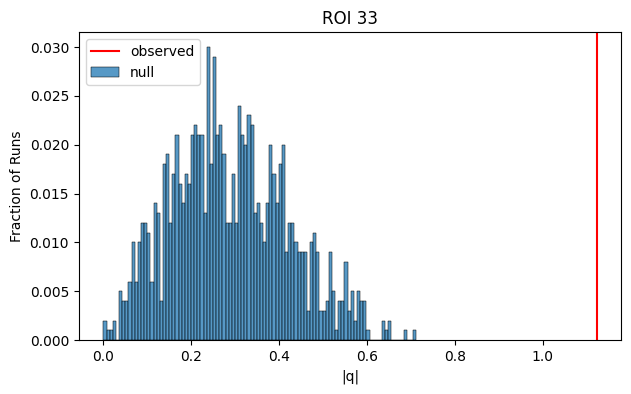

In [79]:
# show the permutation test for the first direction selective ROI
rois = rois_sig_direction

for roi in rois[:3]:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.testTuning(
        counts, dirs, psi=1, niters=1000, show=True, title_name=f"ROI {roi}"
    )

## 4.3 Tuning Curves for the Direction Selective ROIs 

We fitted the von Mises tuning curve to the spike counts per orientation. 

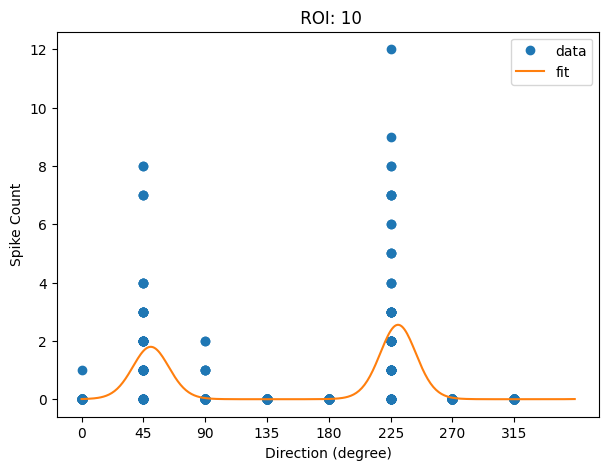

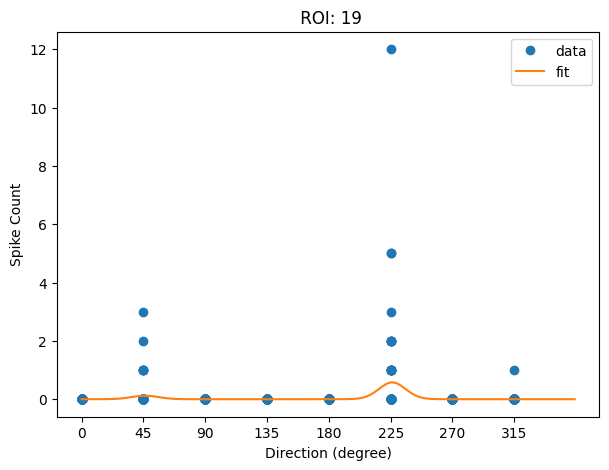

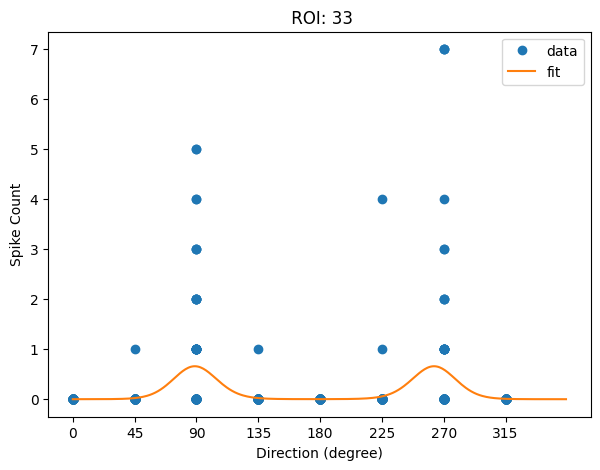

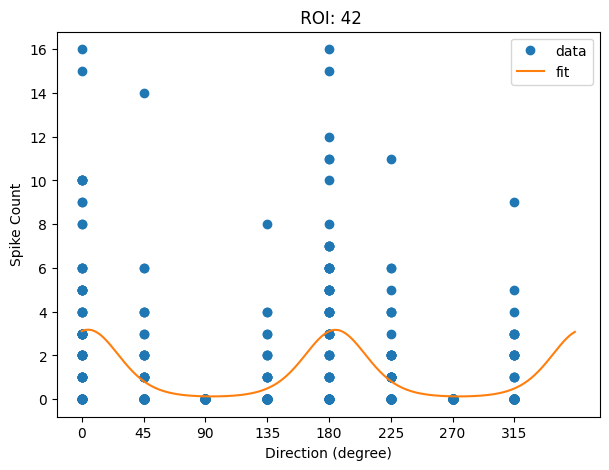

In [80]:
for roi in rois[:4]:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.tuningCurve(counts, dirs, show=True, tile_name=f" ROI: {roi}")

Through vissual assessment we can determine that these ROIs are coding for these directions:

* 45°  and 225°: ROI 10, ROI 19, ROI 51, ROI 84, ROI 102
* 90°  and 270°: ROI 33
* 0°  and 180°: ROI 42, ROI 55, ROI 70, ROI 91
* ~110° and 290°: ROI 54




# 5. Temporal Frequency Analysis 
As seen before in 2.2 the temporal frequency can have a great impact to the response of the ROIs. In this section we will analyze the temporal frequency of the stimulus and the response of the ROIs.


We put 3 criteria for sorting out the noisy spike data before, and maybe we filtered out some ROIs with significant directionality. So we tested the directionality of the ROIs again with respect to the temporal frequency of the stimulus.

## 5.1 Permutation Testing without Restrictions

In [61]:
# permutation test for the temporal frequency tuning

temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

p_dirs_temporal = np.zeros((data["dff"].shape[0], len(temporal_frequencies)))

for i, roi in enumerate(range(data["dff"].shape[0])):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        p_dirs_temporal[i, j] = utils.testTuning(
            counts, dirs, psi=1, niters=1000, show=False
        )[0]

r, t = np.where(p_dirs_temporal < 0.01)
print(
    f"Number of ROIs with significant temporal frequency tuning: {len(np.unique(r))} "
)
print(f"ROIs with significant temporal frequency tuning: {np.unique(r)}")

Number of ROIs with significant temporal frequency tuning: 34 
ROIs with significant temporal frequency tuning: [  7  10  11  12  19  20  21  29  33  40  42  46  48  50  51  54  55  61
  63  64  67  70  71  77  78  81  84  91  96  97  98 100 102 104]


One can see a trend in the significant temporal frequencies. At 1 Hz we have the most significant frequency, and it is declining with increasing frequency.

Text(0.5, 1.0, 'Significant Temporal Frequencies')

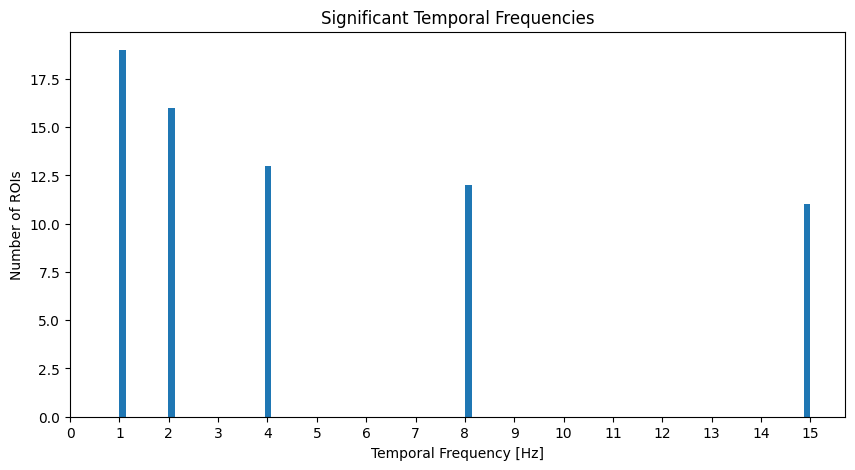

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(temporal_frequencies[t], bins=100)
ax.set_xticks(np.arange(0, 16, 1))
ax.set_xlabel("Temporal Frequency [Hz]")
ax.set_ylabel("Number of ROIs")
ax.set_title("Significant Temporal Frequencies")

## 5.2 Zero Inflated Spike Data 

Here we plot how many ROIs are significant for each temporal frequency, but there is a problem with false positives, because the data is zero inflated. This can be seen with the polar plot of the median of counts per trial for each orientation and temporal frequency.

In [63]:
q = (2.5, 97.5)
(
    median_spikes_temp,
    lower_spikes_temp,
    upper_spikes_temp,
) = utils.spike_orientation_temporal_median(data, spike_data, q)

Here we plot ROI 7 which has a lot of zeros in the trials.

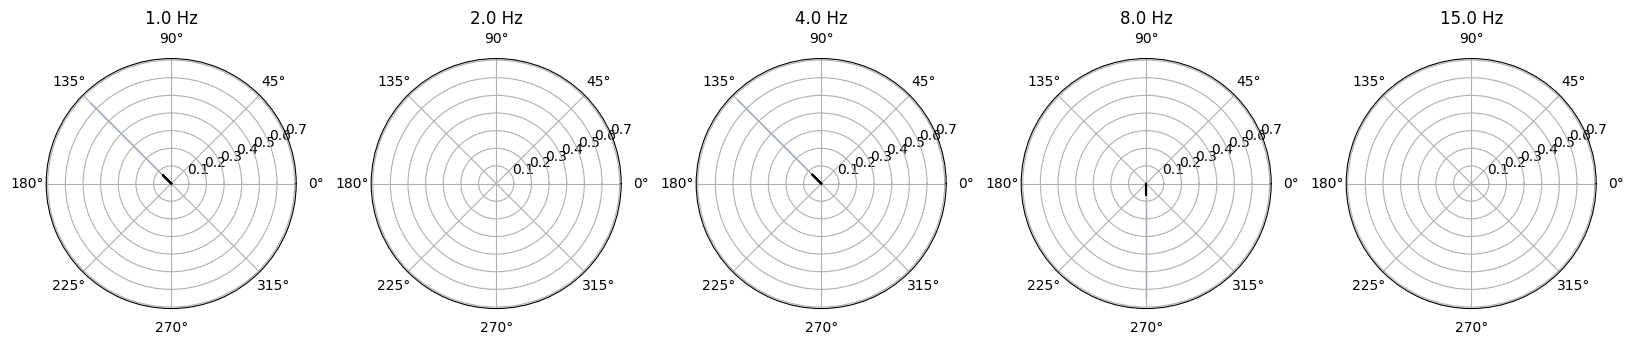

In [64]:
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
roi = 7
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        orientations_polar_plot,
        median_spikes_temp[roi, :, i],
        color="black",
    )
    # add confidence 5 % confidence interval
    ax.fill_between(
        orientations_polar_plot,
        lower_spikes_temp[roi, :, i],
        upper_spikes_temp[roi, :, i],
        alpha=1,
        color="cornflowerblue",
    )

    ax.set_title(f"{temporal_frequencies[i]} Hz")

We fixed the zero inflated data by taking trials of the ROIs with a median equal or greater than 1.

In [65]:
rois_idx, ori_idx, temp_idx = np.where(median_spikes_temp > 1)

In [66]:
# permutation test for the temporal frequency tuning with median greater than 1

temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

rois_sig_temporal = []
tempfreq_updated = []
for i, roi in enumerate(np.unique(rois_idx)):
    for j, freq in enumerate(
        temporal_frequencies[np.unique(temp_idx[rois_idx == roi])]
    ):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        p_dirs_temporal_updated_ = utils.testTuning(
            counts, dirs, psi=1, niters=1000, show=False
        )[0]
        if p_dirs_temporal_updated_ < 0.01:
            rois_sig_temporal.append(roi)
            tempfreq_updated.append(freq)


print(
    f"Number of ROIs with significant temporal frequency tuning and a median over 1: {len(np.unique(rois_sig_temporal))}\n "
)
print(
    f"ROIs with significant temporal frequency tuning:\n {np.unique(rois_sig_temporal)}\n"
)
print(
    f"ROIs that are overall significantly direction selective:\n {rois_sig_direction}\n"
)
print(
    f"All ROIs \n{rois_sig_temporal}, \nthat are significant in these temporal frequencies: \n{tempfreq_updated}"
)

Number of ROIs with significant temporal frequency tuning and a median over 1: 13
 
ROIs with significant temporal frequency tuning:
 [ 10  19  33  42  46  51  54  55  67  70  77  91 102]

ROIs that are overall significantly direction selective:
 [10, 19, 33, 42, 51, 54, 55, 70, 84, 91, 102]

All ROIs 
[10, 10, 10, 10, 10, 19, 33, 33, 42, 42, 42, 46, 51, 51, 51, 54, 54, 54, 55, 55, 67, 70, 70, 77, 77, 77, 91, 91, 91, 102], 
that are significant in these temporal frequencies: 
[1.0, 2.0, 4.0, 8.0, 15.0, 2.0, 4.0, 15.0, 4.0, 8.0, 15.0, 1.0, 1.0, 2.0, 4.0, 4.0, 8.0, 15.0, 1.0, 2.0, 8.0, 1.0, 2.0, 4.0, 8.0, 15.0, 2.0, 4.0, 15.0, 15.0]


The histogramm of the significant temporal frequency did change. We now have more significant ROIs with higher frequencies.

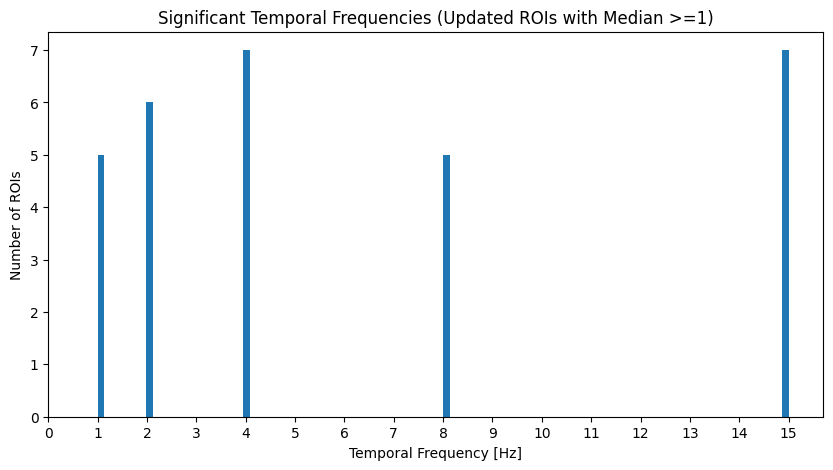

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(tempfreq_updated, bins=100)
ax.set_xticks(np.arange(0, 16, 1))
ax.set_xlabel("Temporal Frequency [Hz]")
ax.set_ylabel("Number of ROIs")
ax.set_title("Significant Temporal Frequencies (Updated ROIs with Median >=1)")
plt.show()

## 5.3 Tuning Curves with Respect to Significant Temporal Frequencies

We plotted the tuning curves with the corresponding significant temporal frequencies. The dotted lines indicate that the tuning curve is significant. We also jittered the spike counts to make the data more visible. 

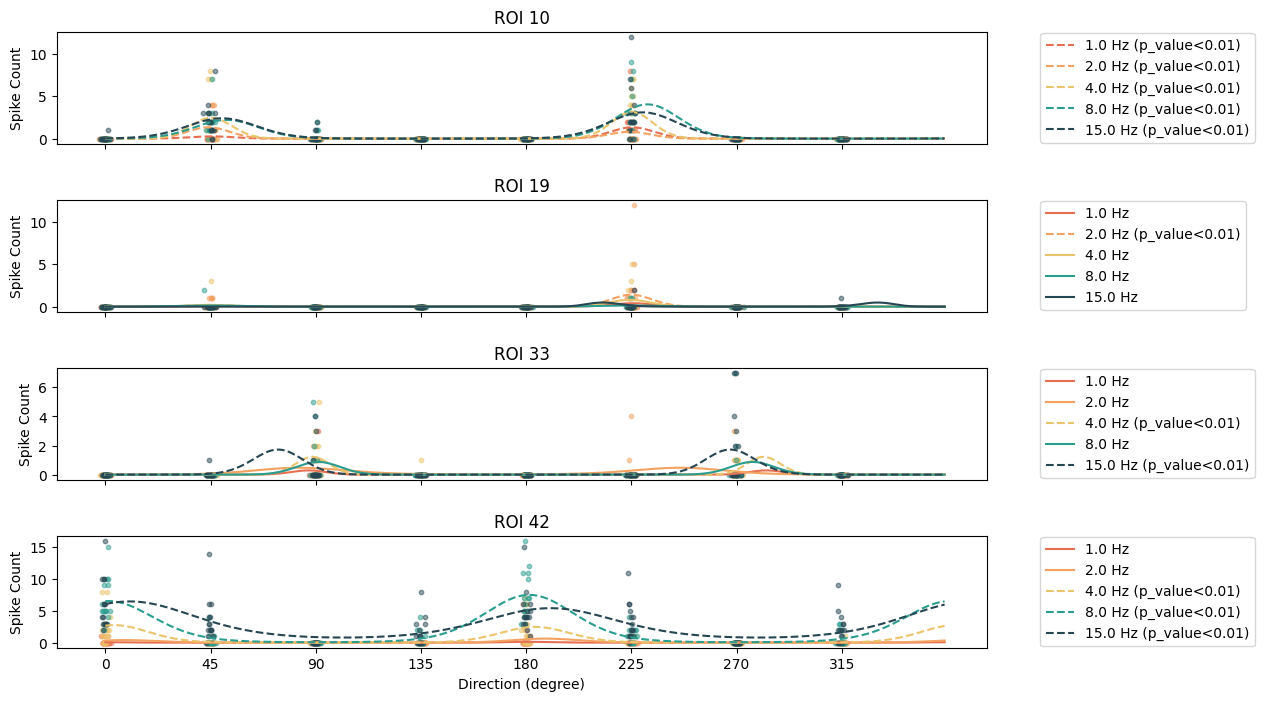

In [68]:
# Tuning curves with respect to the temporal frequency of the drifting grating

plotting_rois = [
    10,
    19,
    33,
    42,
]
peak_tuning_curve = []
peak_temp_freq = []
peak_roi = []
fig, ax = plt.subplots(len(plotting_rois), figsize=(12, 8), sharex=True)
plt.subplots_adjust(hspace=0.5)
for i, roi in enumerate(plotting_rois):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        _, x, y = utils.tuningCurve(
            counts,
            dirs,
            show=False,
        )
        if y is None:
            continue
        if (
            roi in rois_sig_temporal
            and freq in np.array(tempfreq_updated)[np.array(rois_sig_temporal) == roi]
        ):
            ax[i].plot(
                x,
                y,
                label=f"{freq} Hz (p_value<0.01)",
                color=color_temporal_frequencies[j],
                linestyle="dashed",
            )
            peak_tuning_curve.append(np.max(counts))
            peak_temp_freq.append(freq)
            peak_roi.append(roi)
        else:
            ax[i].plot(x, y, label=f"{freq} Hz", color=color_temporal_frequencies[j])
        ax[i].scatter(
            # jitter the x axis
            dirs + np.random.normal(0, 1, len(dirs)),
            counts,
            marker="o",
            color=color_temporal_frequencies[j],
            alpha=0.5,
            s=10,
        )
        ax[i].set_ylabel("Spike Count")
        ax[i].set_title(f"ROI {roi}")
        ax[i].legend(bbox_to_anchor=(1.05, 1.05), loc="upper left")

    ax[-1].set_xlabel("Direction (degree)")
    ax[-1].set_xticks(np.arange(0, 360, 45))

## 5.4 Temporal Frequency Conclusion

We can see that we get the same ROIs as before, but now with more information about the temporal frequency. We have two more ROIs than before with this method and those two (46 and 77) got previously filtered out by the criteria iii) (only chose ROIs that had at least 75% of their activity in the stimulus presentation period). 

# 6. Plotting the PSTH for Orientation / Direction Selective ROIs

Here we wanted to visualize the rate and and timing of the spikes before, during and after the stimulus presentation. For this we plotted a PSTH for each orientation of the stimulus for three example ROIs. We calculated the mean instantaneous firing rate for each orientation at every time point and then plotted the PSTH. The gray background indicates the stimulation time. For the example ROIs, we used ROIs that were selective for a preferred orientation as well as direction. We can see that the firing rate increases during the stimulus presentation and then decreases after the stimulus is removed. We can also see that the firing rate is higher for the preferred orientation of the neuron. 


In [69]:
# creating a spike table and calculating the instantaneous firing rate of each significantly selective ROI
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
SpikeTable_df = pd.DataFrame(columns=rois)
instant_firing_rate_df = pd.DataFrame(columns=rois, index=orientations)

# selecting a time window that we want to visualize
prestim = 15  # index
poststim = 15
time_window = prestim + poststim + 59

for j, l in enumerate(rois):
    # create a spike table with columns for every time entry and rows for every trial
    SpikeTable = np.zeros((len(data["stim_table"]["start"]), time_window))
    for i in range(len(data["stim_table"]["start"])):
        starts = data["stim_table"]["start"][i]
        ends = data["stim_table"]["end"][i]
        # not every trial has the same length, so we need to make sure that the spike table has the same length for every trial
        # we do this by cutting off the end of the trial if it is longer than the time window
        if len(spike_data[l][int(starts) - prestim : int(ends) + poststim]) >= 90:
            difference = (
                len(spike_data[l][int(starts) - prestim : int(ends) + poststim])
                - time_window,
            )[0]
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim - difference
            ]
        else:
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim
            ]
    SpikeTable = np.array(SpikeTable, dtype=object)
    SpikeTable_df[l] = [SpikeTable]
    # calculate the instantaneous firing rate for every trial and every orientation and
    # saving the mean firing rate for every orientation
    for m, orientation in enumerate(orientations):
        instant_firing_rate_df[l][m] = (
            np.nanmean(
                SpikeTable_df[l][0][
                    data["stim_table"]["orientation"] == orientation, :
                ],
                axis=0,
            )
            * 30  # convert to Hz
        )

# smooth the firing rates of example ROIs
smoothed_firing_rates_10 = utils.smooth_rate(data, instant_firing_rate_df[10], 7)
smoothed_firing_rates_91 = utils.smooth_rate(data, instant_firing_rate_df[91], 7)
smoothed_firing_rates_70 = utils.smooth_rate(data, instant_firing_rate_df[70], 7)

/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_2422/2425867380.py:37: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  instant_firing_rate_df[l][m] = (
/Users/acfw/Documents/uni_tuebingen/neuraldatascience/notebooks/utils_project1.py:700: RuntimeWarning: Mean of empty slice
  smoothed_rate[i, j] = np.nanmean(


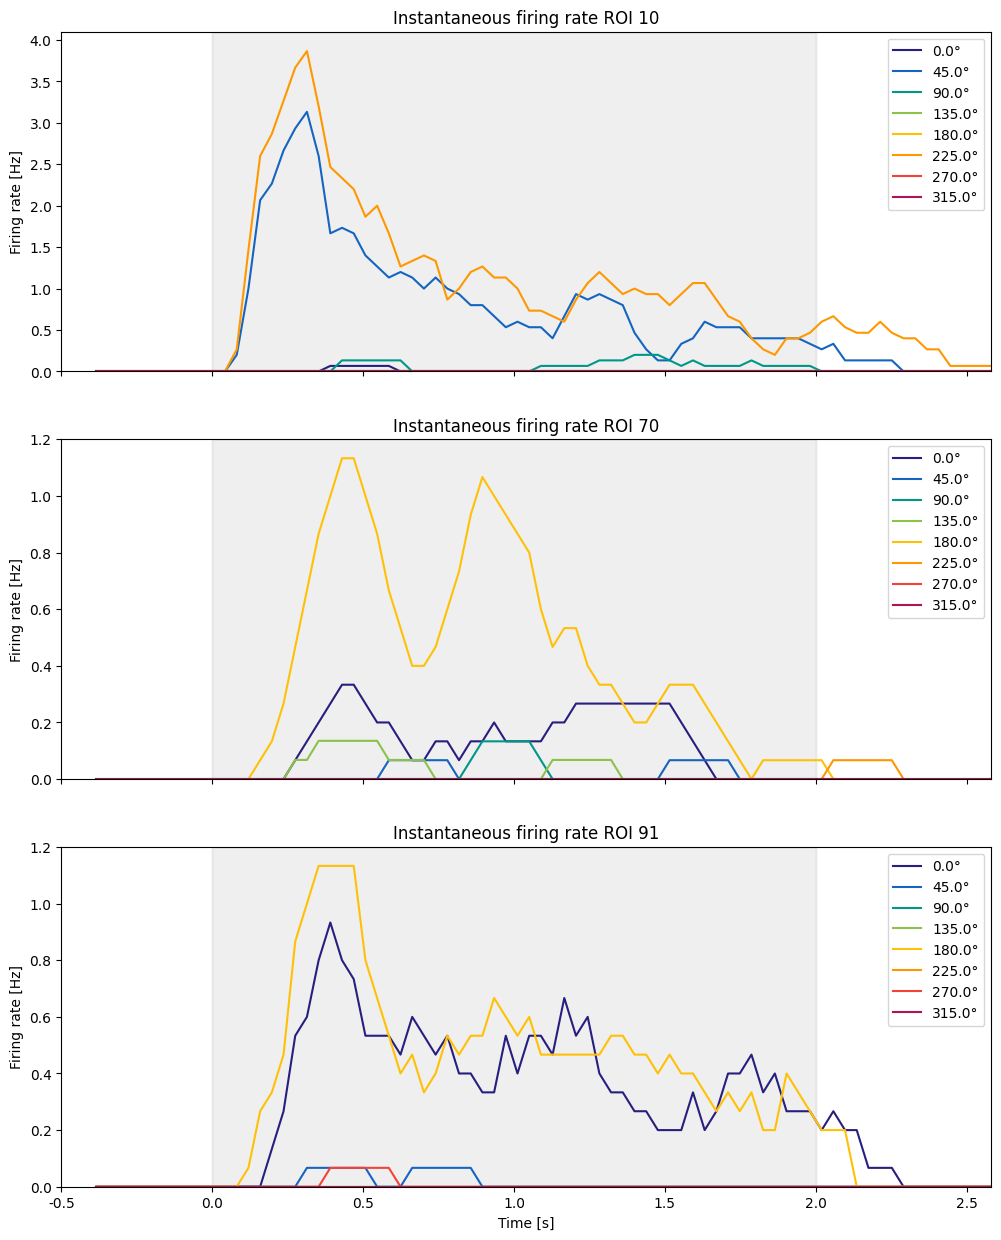

In [70]:
# plot PSTHs for every orientation
fig, axs = plt.subplots(3, figsize=(12, 15), sharex=True)
for i in range(len(orientations)):
    axs[0].plot(
        np.arange(len(smoothed_firing_rates_10[0])) / 30,
        smoothed_firing_rates_10[i],
        label=f"{orientations[i]}°",
        color=color_directions[i],
    )
    axs[0].set_title("Instantaneous firing rate ROI 10")
    axs[0].set_ylabel("Firing rate [Hz]")
    axs[0].axvspan(0.43, 2.15, alpha=0.01, color="grey")
    axs[0].set_ylim(0, 4.1)
    axs[0].set_xlim(0, 2.65)

    axs[1].plot(
        np.arange(len(smoothed_firing_rates_70[0])) / 30,
        smoothed_firing_rates_70[i],
        label=f"{orientations[i]}°",
        color=color_directions[i],
    )
    axs[1].set_title("Instantaneous firing rate ROI 70")
    axs[1].set_ylabel("Firing rate [Hz]")
    axs[1].axvspan(0.43, 2.15, alpha=0.01, color="grey")
    axs[1].set_ylim(0, 1.2)

    axs[2].plot(
        np.arange(len(smoothed_firing_rates_91[0])) / 30,
        smoothed_firing_rates_91[i],
        label=f"{orientations[i]}°",
        color=color_directions[i],
    )
    axs[2].axvspan(0.43, 2.15, alpha=0.01, color="grey")
    axs[2].set_title("Instantaneous firing rate ROI 91")
    axs[2].set_ylabel("Firing rate [Hz]")
    axs[2].set_xticks(np.arange(0, 90, 12.9) / 30)
    axs[2].set_xticklabels(np.arange(-0.5, 3, 0.5))
    axs[2].set_xlabel("Time [s]")
    axs[2].set_ylim(0, 1.2)

axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

# 7. Plotting the Spatial Structure of Orientation and Direction Selective ROIs

In this section we wanted to show if the significant ROIs with a preferred orientation, direction or temporal frequency are spatially close in the ROI masks. 
Furthermore we wanted to look at which temporal frequency has the highest response and where these ROIs are located. 

To achieve this, we plotted the significant ROIs onto the maximum projection and colored them by the respective stimulus category. All ROIs that had the highest activity for the same direction, orientation or temporal frequency were plotted in the same color.

In [71]:
# calculate the mean spike orientation and its standard deviation
mean_spike_orientation, std_spike_orientation = utils.spike_orientation_mean(
    data, spike_data
)

In [72]:
# calculating the peak temporal frequency for the ROIs that are significantly tuned to temporal frequency
peak_tuning_curve = []
peak_temp_freq = []
peak_roi = []

for i, roi in enumerate(np.unique(rois_sig_temporal)):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = utils.get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        _, x, y = utils.tuningCurve(
            counts,
            dirs,
            show=False,
        )
        if y is None:
            continue
        if (
            roi in rois_sig_temporal
            and freq in np.array(tempfreq_updated)[np.array(rois_sig_temporal) == roi]
        ):
            peak_tuning_curve.append(np.max(counts))
            peak_temp_freq.append(freq)
            peak_roi.append(roi)

peak_tuning_curve = np.array(peak_tuning_curve)
peak_temp_freq = np.array(peak_temp_freq)
peak_roi = np.array(peak_roi)

In [73]:
rois_temp_freq_sig = []
freq_temp_sig = []
for roi in np.unique(peak_roi):
    tfreqs = peak_temp_freq[peak_roi == roi]
    tcounts = peak_tuning_curve[peak_roi == roi]
    best_freq = tfreqs[np.argmax(tcounts)]
    rois_temp_freq_sig.append(roi)
    freq_temp_sig.append(best_freq)

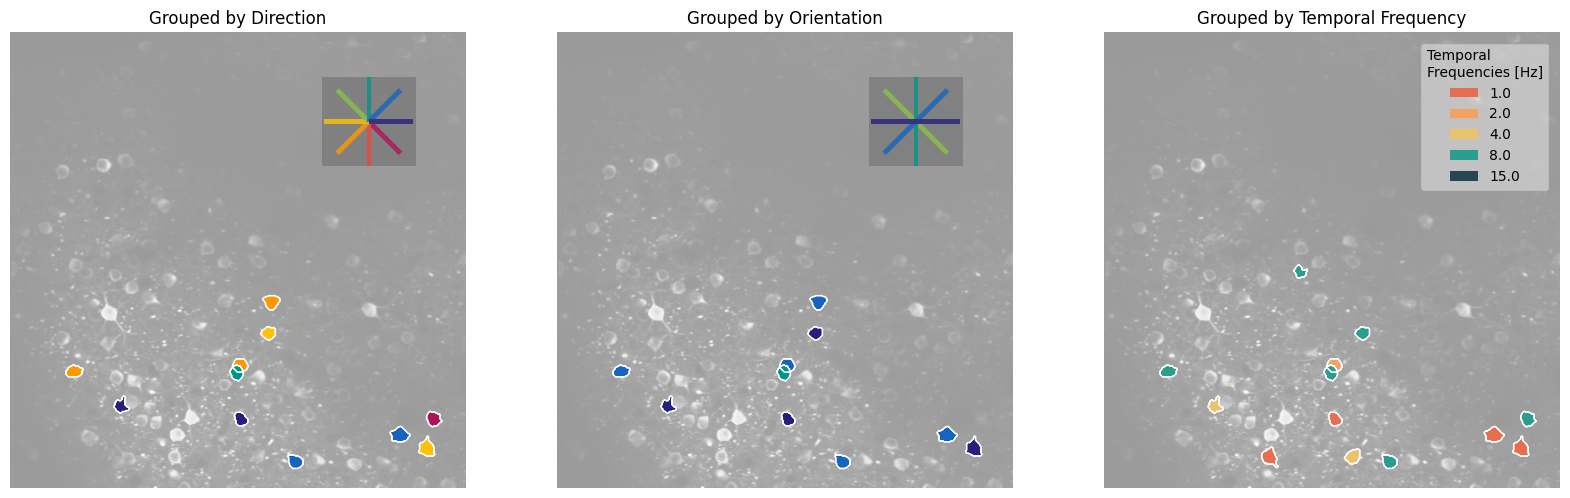

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.imshow(data["max_projection"], cmap="gray", alpha=0.4)
ax2.imshow(data["max_projection"], cmap="gray", alpha=0.4)
ax3.imshow(data["max_projection"], cmap="gray", alpha=0.4)

ax1.set_title("Grouped by Direction")
ax2.set_title("Grouped by Orientation")
ax3.set_title("Grouped by Temporal Frequency")

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")


if "coustom" in matplotlib.colormaps():
    matplotlib.colormaps.unregister("coustom")

ncolors = 256

# Plot all ROIs that are significant for direction
for roi in rois_sig_direction:
    matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    max_orientation = np.argmax(mean_spike_orientation[roi, :])
    matrix[x, y] = 1

    color_array = ["#00000000", color_directions[max_orientation]]
    map_object = LinearSegmentedColormap.from_list(name="coustom", colors=color_array)
    matplotlib.colormaps.register(cmap=map_object)

    ax1.imshow(matrix, alpha=1, cmap="coustom", vmin=0, vmax=1)
    ax1.contour(
        matrix,
        colors="white",
        linewidths=0.5,
    )
    # ad patches to the imshow with the color of the direction
    rpoint = (402.5, 100)
    P = [
        mp.Rectangle(
            (rpoint[0] - 2.5, rpoint[1]),
            5,
            50,
            facecolor=color_directions[::-1][1:][i],
            edgecolor="none",
            # to get the right angle we have to substract 45 degrees
            angle=orientations[~np.isnan(orientations)][i] - 45,
            rotation_point=rpoint,
        )
        for i in range(8)
    ]
    for i in range(8):
        ax1.add_patch(P[i])
    patch_benethe = mp.Rectangle(
        (rpoint[0] - 52.5, rpoint[1] - 50),
        105,
        100,
        facecolor="gray",
        edgecolor="none",
        alpha=0.2,
    )
    ax1.add_patch(patch_benethe)

    matplotlib.colormaps.unregister("coustom")

# Plot all ROIs that are significant for orientation
for roi in rois_sig_orientation:
    matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    max_orientation = np.argmax(mean_spike_orientation[roi, :])
    if max_orientation > 3:
        max_orientation = max_orientation - 4
    matrix[x, y] = 1

    color_array = ["#00000000", color_orientations[max_orientation]]
    map_object = LinearSegmentedColormap.from_list(name="coustom", colors=color_array)
    matplotlib.colormaps.register(cmap=map_object)

    ax2.imshow(matrix, alpha=1, cmap="coustom", vmin=0, vmax=1)
    ax2.contour(
        matrix,
        colors="white",
        linewidths=0.5,
    )
    # ad patches to the imshow with the color of the direction
    rpoint = (402.5, 100)
    P = [
        mp.Rectangle(
            (rpoint[0] - 2.5, 50),
            5,
            100,
            facecolor=color_orientations[::-1][i],
            edgecolor="none",
            # to get the right angle we have to substract 45 degrees
            angle=orientations[~np.isnan(orientations)][i] - 45,
            rotation_point="center",
        )
        for i in range(4)
    ]
    for i in range(4):
        ax2.add_patch(P[i])
    patch_benethe = mp.Rectangle(
        (rpoint[0] - 52.5, rpoint[1] - rpoint[1] / 2),
        105,
        100,
        facecolor="gray",
        edgecolor="none",
        alpha=0.2,
    )
    ax2.add_patch(patch_benethe)
    matplotlib.colormaps.unregister("coustom")

# Plot all ROIs that are significant for temporal frequency
freq_index = np.zeros(len(freq_temp_sig))
for i, freq in enumerate(np.unique(freq_temp_sig)):
    freq_index[freq_temp_sig == freq] = i
freq_index = np.asarray(freq_index, dtype=int)

for roi in np.unique(rois_temp_freq_sig):
    matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    matrix[x, y] = 1

    color_array = [
        "#00000000",
        color_temporal_frequencies[freq_index[rois_temp_freq_sig == roi][0]],
    ]
    map_object = LinearSegmentedColormap.from_list(name="coustom", colors=color_array)
    matplotlib.colormaps.register(cmap=map_object)

    ax3.imshow(matrix, alpha=1, cmap="coustom", vmin=0, vmax=1)
    ax3.contour(
        matrix,
        colors="white",
        linewidths=0.5,
    )
    matplotlib.colormaps.unregister("coustom")
freq_temp_patches = [
    mp.Rectangle(
        (0, 0),
        1,
        1,
        fc=color_temporal_frequencies[i],
    )
    for i in range(len(color_temporal_frequencies))
]
ax3.legend(
    freq_temp_patches,
    temporal_frequencies,
    loc="upper right",
    bbox_to_anchor=(0.99, 0.99),
    title="Temporal \nFrequencies [Hz]",
    framealpha=0.4,
)

We can see that for the ROIs that have significant direction tuning, there is not a clear spatial pattern. Whereas for the ROIs with orientation tuning, we can see that this is a region of V1 where only ROIs selective for the orientations 0°-180°, 45°-225° and 90°-270° of the stimulus were recorded. The ROIs that have significant tuning for the temporal frequency also did not show a pattern.

# 8. General Conclusion

We can clearly see that in this dataset we have direction and orientation selective ROIs, that are also significant with the permutation method. The temporal frequency is influencing the selectivity of the ROIs, what we can see in ROI 10 which shows an increase of selectivity for a direction / orientation with increasing temporal frequency. We also found that only one ROI is exclusively direction selective. We also did a PSTH to visualize the temporal dynamics of the response to the stimulus, and estimated that there are differences in the temporal dynamics of each ROI. To answer the question if there is a preffered spatial structure, we could not visually assess any specific spatial structure, only that there are mostly orientation selective ROIs with the preferred orientation of 0°-180° and 45°-225° degrees in this recorded region of V1.

With this analysis it is possible to group the ROIs by their preferred direction, orientaton and temporal frequency.

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

We also looked at: 

5. Temporal frequencies
6. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.